<a href="https://colab.research.google.com/github/musab-r/Computational_Intelligence_Project/blob/main/Phase%202%20NN%2C%20FS%2C%20GA/Genetic_Algo_Imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Intelligence Project: Sentiment Analysis on IMDB dataset Using Genetic Algorithm

In [1]:
import keras
# import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import load_model
import matplotlib.pyplot as plt
from operator import itemgetter 
from keras import regularizers, optimizers, losses, metrics
from keras.utils import np_utils, to_categorical
# warnings.filterwarnings('ignore')
# get_ipython().magic(u'matplotlib inline')
# plt.style.use('ggplot')

### Loading Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
print("train_data ", X_train.shape)
print("train_labels ", y_train.shape)
print("_"*100)
print("test_data ", X_test.shape)
print("test_labels ", y_test.shape)
print("_"*100)
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in X_train]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in X_train]))

train_data  (25000,)
train_labels  (25000,)
____________________________________________________________________________________________________
test_data  (25000,)
test_labels  (25000,)
____________________________________________________________________________________________________
Maximum value of a word index 
4999
Maximum length num words of review in train 
2494


### Vectorization

In [4]:
def vectorize_sequences(sequences, dimension=6000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [5]:
x_train = vectorize_sequences(X_train)
x_test = vectorize_sequences(X_test)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 6000)
x_test  (25000, 6000)


In [6]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)


### Splitting Dataset into Smaller Chunk

In [12]:
x_train = x_train[:6000]
y_train = y_train[:6000]
x_test = x_test[:6000]
y_test = y_test[:6000]

In [13]:
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (6000,)
y_test  (6000,)


### Neuro Genetic Model

In [14]:
class Network:
    def __init__(self):
        model = Sequential()
        model.add(Dense(16, kernel_regularizer=regularizers.l1(0.0001), activation='relu', input_shape=(6000,)))
        model.add(Dropout(0.5))
        model.add(Dense(16, kernel_regularizer=regularizers.l1(0.0001),activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid')) 

        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
        self.acc_history = []
        # self.model_count = 1
    
    def return_acc_history(self):
        return self.acc_history
    
    def get_layer_weight(self,i):
        return self.model.layers[i].get_weights()
    
    def set_layer_weight(self,i,weight):
        self.model.layers[i].set_weights(weight)
    
    # def plot_history(self, history):
    #     plt.clf()
    #     history_dict = history.history
    #     loss_values = history_dict['loss']
    #     val_loss_values = history_dict['val_loss']
    #     epochs = range(1, (len(history_dict['loss']) + 1))
    #     plt.plot(epochs, loss_values, 'bo', label='Training loss')
    #     plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    #     plt.title('Training and validation loss of Network #'+ str(self.model_count))
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Loss')
    #     plt.legend()
    #     plt.show()

    def train(self):
        self.model.fit(x_train, y_train, epochs=1, batch_size=16, verbose = 1,shuffle = True)

    def test(self):
        loss, acc = self.model.evaluate(x_test,y_test)
        self.acc_history.append(acc)
        # self.plot_history(self.history)
        # self.model_count += 1
        return acc
    
    def load_layer_weights(self,weights):
        self.model.set_weights(weights) 
    
    def give_weights(self):
        return self.model.get_weights()
    def weight_len(self):
        i = 0 
        for j in self.model.layers:
            i+=1
        return i 
    def architecture(self):
        self.model.summary()

### Genetic Algorithm

In [15]:
 class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations = 10):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = None
        self.children_population_weights = []
        self.acces = []
        self.norm_acces = []
        
    def create_population(self):
        self.population = [Network() for i in range(self.population_size)]
    
    def train_generation(self):
        for member in self.population:
                member.train()
                
    def predict(self):
        for member in self.population:
                acc = member.test()
                self.acc.append(acc)
                #logging.info("Losses: {}".format(loss))
    
    def normalize(self):
        sum_ = sum(self.acc)
        self.norm_acc = [i/sum_ for i in self.acc] 
        print("\nNormalization sum: ",sum(self.norm_acc))
        #assert sum(self.norm_acc) == 1
        
    def show_weights(self):
        for i in parent_weights:
            print(i)
    def clear_losses(self):
        self.norm_acc = []
        self.acc = []
        
    def mutate(self):
        for member in self.population:
            for i in range(member.weight_len()):
                if np.random.random() < self.mutation_rate:
                    print("\nMutation!")
                    old_weight = member.get_layer_weight(i)
                    new_weight = [np.random.uniform(low=-1, high=1, size=old_weight[i].shape) for i in range(len(old_weight))]
                    member.set_layer_weight(i, new_weight)
    
    def reproduction(self):
        """ 
        Reproduction through midpoint crossover method 
        """
        population_idx = [i for i in range(len(self.population))]
        for i in range(len(self.population)):
        #selects two parents probabilistic accroding to the fitness
            if sum(self.norm_acc) != 0:
                parent1 = np.random.choice(population_idx, p = self.norm_acc)
                parent2 = np.random.choice(population_idx, p = self.norm_acc)
            else:
              # if there are no "best" parents choose randomly 
                parent1 = np.random.choice(population_idx)
                parent2 = np.random.choice(population_idx)

            # picking random midpoint for crossing over name/DNA
            parent1_weights = self.population[parent1].give_weights()
            parent2_weights = self.population[parent2].give_weights()
            
            
            mid_point = np.random.choice([i for i in range(len(parent1_weights))])
            # adding DNA-Sequences of the parents to final DNA
            self.children_population_weights.append(parent1_weights[:mid_point] + parent2_weights[mid_point:])
        # old population gets the new and proper weights
        for i in range(len(self.population)):
            for j in range(len(self.children_population_weights)):
                self.population[i].load_layer_weights(self.children_population_weights[j])
        
        
    
    def run_evolution(self):
        for episode in range(self.generations):
            self.clear_losses()
            self.train_generation()
            self.predict()
            if episode != self.generations -1:
                self.normalize()
                self.reproduction()
                self.mutate()
            else:
                pass
        
        # plotting history:
        for a in range(self.generations):
            for member in self.population:
                plt.plot(member.acc_history)
        plt.xlabel("Generations")
        plt.ylabel("Accuracy")
        plt.show()

188/188 [==============================] - 0s 2ms/step - loss: 0.5295 - accuracy: 0.8330

Normalization sum:  1.0
188/188 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8567

Normalization sum:  0.9999999999999999
188/188 [==============================] - 0s 2ms/step - loss: 0.3952 - accuracy: 0.8565

Normalization sum:  1.0
188/188 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.8398

Normalization sum:  1.0
188/188 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8513

Normalization sum:  1.0

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4400 - accuracy: 0.8350

Normalization sum:  1.0

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.8407

Normalization sum:  0.9999999999999999
188/188 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.8153

Normalization sum:  1.0

Mutation!
188/188 [=====

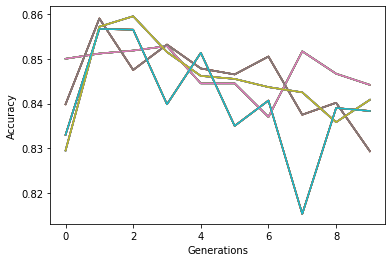

In [18]:
GA = GeneticAlgorithm(population_size = 4,mutation_rate = 0.05, generations = 10)
GA.create_population()
GA.run_evolution()

188/188 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.8507

Normalization sum:  1.0

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8580

Normalization sum:  0.9999999999999999

Mutation!

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.8473

Normalization sum:  1.0000000000000002

Mutation!

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8450

Normalization sum:  1.0

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.8403

Normalization sum:  1.0

Mutation!

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.8240

Normalization sum:  1.0

Mutation!

Mutation!

Mutation!
188/188 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.8450

Normalization sum:  1.0

Mutati

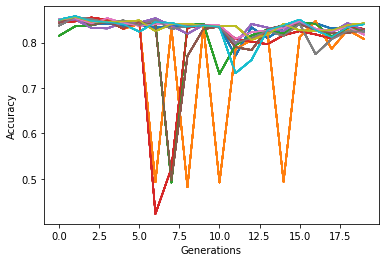

In [19]:
GA = GeneticAlgorithm(population_size = 10,mutation_rate = 0.05, generations = 20)
GA.create_population()
GA.run_evolution()

In [30]:
import os
os.chdir('/content/drive/My Drive/Computational Intelligence/')

In [31]:
!pwd

/content/drive/My Drive/Computational Intelligence


In [32]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-generic-recommended is already the newest version (2017.20180305-1).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [33]:
!jupyter nbconvert --to pdf Genetic_Algo_Imdb.ipynb

[NbConvertApp] Converting notebook Genetic_Algo_Imdb.ipynb to pdf
[NbConvertApp] Support files will be in Genetic_Algo_Imdb_files/
[NbConvertApp] Making directory ./Genetic_Algo_Imdb_files
[NbConvertApp] Making directory ./Genetic_Algo_Imdb_files
[NbConvertApp] Writing 95076 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 106832 bytes to Genetic_Algo_Imdb.pdf
